In [1]:
import os
import sys
sys.path.append('..')
sys.path.append('../Automatic-Circuit-Discovery/')
sys.path.append('../tracr/')
import IPython
ipython = get_ipython()
if ipython is not None:
    ipython.magic('load_ext autoreload')
    ipython.magic('autoreload 2')
import torch as t
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt

from acdc.docstring.utils import get_all_docstring_things
from utils.prune_utils import get_3_caches, split_layers_and_heads
from ACDCPPExperiment import ACDCPPExperiment
device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(device)

/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_7881/2228394017.py:9: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic('load_ext autoreload')
/var/folders/tn/nyh0947d6sngjfvtp7hbb0jr0000gn/T/ipykernel_7881/2228394017.py:10: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic('autoreload 2')
/Users/canrager/.pyenv/versions/acdc_env/envs/acdcpp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


In [2]:
all_docstring_items = get_all_docstring_things(num_examples=40, seq_len=5, device=device, metric_name='docstring_metric', correct_incorrect_wandb=False)

tl_model = all_docstring_items.tl_model
validation_metric = all_docstring_items.validation_metric
validation_data = all_docstring_items.validation_data
validation_labels = all_docstring_items.validation_labels
validation_patch_data = all_docstring_items.validation_patch_data
test_metrics = all_docstring_items.test_metrics
test_data = all_docstring_items.test_data
test_labels = all_docstring_items.test_labels
test_patch_data = all_docstring_items.test_patch_data

Loaded pretrained model attn-only-4l into HookedTransformer
Moving model to device:  cpu


In [3]:
def abs_docstring_metric(logits):
    return -abs(test_metrics['docstring_metric'](logits))

## Show # pruned nodes edges / nodes over threshold

In [7]:
## Calc Node attributions

clean_cache, corrupted_cache, clean_grad_cache = get_3_caches(tl_model, test_data, test_patch_data, test_metrics['docstring_metric'], mode="node")
# compute first-order Taylor approximation for each node to get the attribution
clean_head_act = clean_cache.stack_head_results()
corr_head_act = corrupted_cache.stack_head_results()
clean_grad_act = clean_grad_cache.stack_head_results()

# compute attributions of each node
node_attr = (clean_head_act - corr_head_act) * clean_grad_act
# separate layers and heads, sum over d_model (to complete the dot product), batch, and seq
node_attr = split_layers_and_heads(node_attr, tl_model).sum((2, 3, 4)).flatten().abs()

In [8]:
## Calc edge attributions

threshold_dummy = 0.1 # Does not make a difference when only running edge based attribution patching, as all attributions are saved in the result dict anyways
RUN_NAME = 'greaterthan_edge_absval'
acdcpp_exp = ACDCPPExperiment(tl_model,
                              test_data,
                              test_patch_data,
                              test_metrics['docstring_metric'],
                              abs_docstring_metric,
                              threshold_dummy,
                              run_name=RUN_NAME,
                              verbose=False,
                              attr_absolute_val=True,
                              save_graphs_after=0,
                              pruning_mode="edge",
                              no_pruned_nodes_attr=1
                             )
tlacdc_exp = acdcpp_exp.setup_exp(threshold=threshold_dummy)
attr_results = acdcpp_exp.run_acdcpp(exp=tlacdc_exp, threshold=threshold_dummy)

ln_final.hook_normalized
ln_final.hook_scale
blocks.3.hook_resid_post
blocks.3.hook_attn_out
blocks.3.attn.hook_result
blocks.3.attn.hook_z
blocks.3.attn.hook_pattern
blocks.3.attn.hook_attn_scores
blocks.3.attn.hook_v
blocks.3.attn.hook_k
blocks.3.attn.hook_q
blocks.3.ln1.hook_normalized
blocks.3.ln1.hook_scale
blocks.3.hook_v_input
blocks.3.hook_k_input
blocks.3.hook_q_input
blocks.3.hook_resid_pre
blocks.2.hook_resid_post
blocks.2.hook_attn_out
blocks.2.attn.hook_result
blocks.2.attn.hook_z
blocks.2.attn.hook_pattern
blocks.2.attn.hook_attn_scores
blocks.2.attn.hook_v
blocks.2.attn.hook_k
blocks.2.attn.hook_q
blocks.2.ln1.hook_normalized
blocks.2.ln1.hook_scale
blocks.2.hook_v_input
blocks.2.hook_k_input
blocks.2.hook_q_input
blocks.2.hook_resid_pre
blocks.1.hook_resid_post
blocks.1.hook_attn_out
blocks.1.attn.hook_result
blocks.1.attn.hook_z
blocks.1.attn.hook_pattern
blocks.1.attn.hook_attn_scores
blocks.1.attn.hook_v
blocks.1.attn.hook_k
blocks.1.attn.hook_q
blocks.1.ln1.hook_nor

100%|██████████| 3104/3104 [00:01<00:00, 1670.75it/s]


Text(0.5, 1.0, 'Number of remaining edges/nodes after ACDC++ only \n(Docstring task, ADCD threshold: 0.067)')

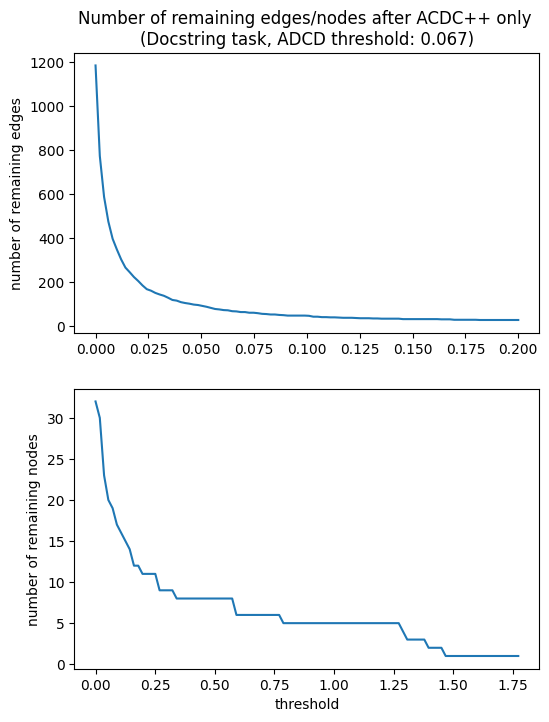

In [9]:
attr_vals = np.array(list(attr_results[1].values()))
thresholds_edge = np.linspace(min(attr_vals), 0.2, 100)
thresholds_node = np.linspace(min(attr_vals), max(attr_vals), 100)
num_edges_above_thresh = np.array(
    [sum(attr_vals > t) for t in thresholds_edge]
)
num_nodes_above_thresh = np.array(
    [sum(node_attr > t) for t in thresholds_node]
)



fig, ax = plt.subplots(2,1, figsize=(6,8))

ax[0].plot(thresholds_edge, num_edges_above_thresh)
ax[1].plot(thresholds_node, num_nodes_above_thresh)
ax[1].set_xlabel("threshold")
ax[0].set_ylabel("number of remaining edges")
ax[1].set_ylabel("number of remaining nodes")
ax[0].set_title("Number of remaining edges/nodes after ACDC++ only \n(Docstring task, ADCD threshold: 0.067)")